In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             brier_score_loss, precision_recall_curve)
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parents[2] / "src" / "python"))
from paths import training_path, models_path

In [3]:
df = pd.read_csv(training_path / "vcf_feature_vectors.csv")

non_features = ["CHROM", "POS", "REF", "ALT", "GOLDEN"]
features = df.drop(columns=non_features)
target = df["GOLDEN"]

In [4]:
number_of_features = len(features.columns)
print(f"Number of features {number_of_features}")

Number of features 20


In [5]:
features_to_keep = 8

In [6]:
mi_scores = mutual_info_classif(features, target, discrete_features=False, random_state=42)
mi_df = pd.DataFrame({
    "Feature": features.columns,
    "MI_Score": mi_scores
}).sort_values(by="MI_Score", ascending=False)

print("\nTop Features by Mutual Information with GOLDEN:")
print(mi_df)


Top Features by Mutual Information with GOLDEN:
     Feature  MI_Score
12      TLOD  0.204326
17  F1R2_alt  0.187431
19  F2R1_alt  0.186728
14    AD_alt  0.182620
15        AF  0.166876
10     NALOD  0.153232
11      NLOD  0.124146
4    MBQ_alt  0.082166
1       ECNT  0.061768
6   MFRL_alt  0.058872
9       MPOS  0.058713
8    MMQ_alt  0.056644
13    AD_ref  0.044250
16  F1R2_ref  0.036965
18  F2R1_ref  0.036343
7    MMQ_ref  0.032510
0         DP  0.018202
3    MBQ_ref  0.012332
5   MFRL_ref  0.008127
2      GERMQ  0.007170


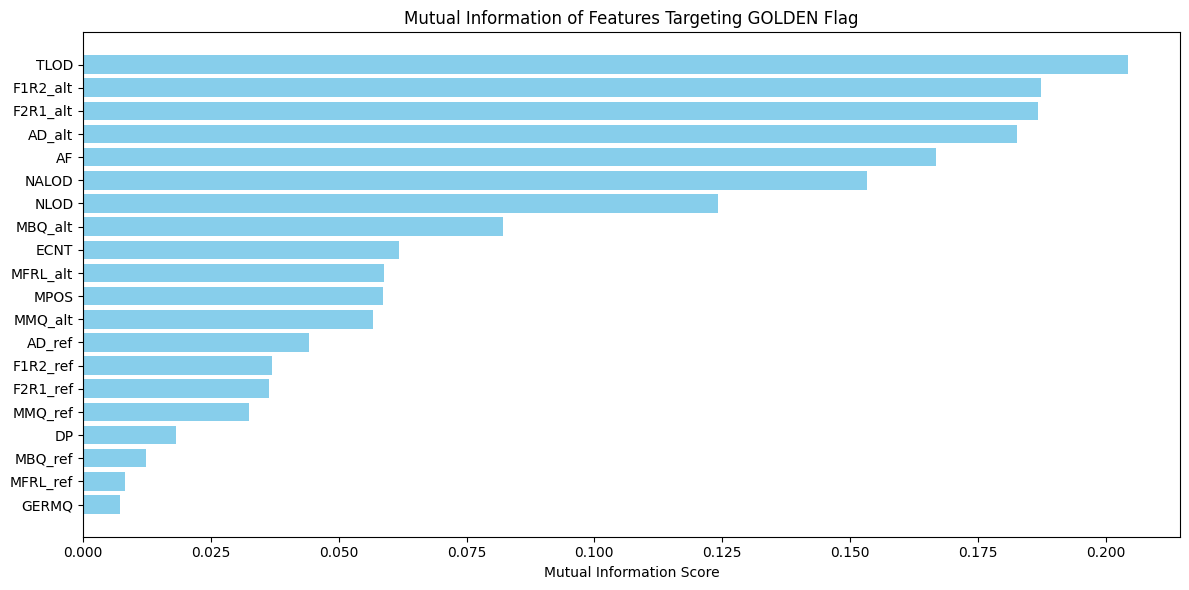

In [7]:
plt.figure(figsize=(12, 6))
plt.barh(mi_df["Feature"], mi_df["MI_Score"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Mutual Information of Features Targeting GOLDEN Flag")
plt.xlabel("Mutual Information Score")
plt.tight_layout()
plt.show()

In [8]:
# Either keep N number of top features or use them all
top_features = mi_df["Feature"].head(features_to_keep).tolist()
X = df[top_features]
y = target

In [9]:
# Stratified K-Fold + SHAP per test fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
shap_values_all = []
X_test_all = []
best_thresholds = []
metrics_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = lgb.LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)

    # SHAP explanation
    explainer = shap.Explainer(model)
    shap_values_fold = explainer(X_test)
    shap_values_all.append(shap_values_fold.values)
    X_test_all.append(X_test)

    # Threshold tuning
    y_proba = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_thresholds.append(best_thresh)

    # Apply optimal threshold
    y_pred = (y_proba >= best_thresh).astype(int)

    # Metrics
    metrics = {
        "Fold": fold+1,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Average Precision (PR AUC)": average_precision_score(y_test, y_proba),
        "Brier Score": brier_score_loss(y_test, y_proba),
        "Best Threshold": best_thresh
    }
    metrics_list.append(metrics)

[LightGBM] [Info] Number of positive: 7214, number of negative: 78663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 85877, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084004 -> initscore=-2.389149
[LightGBM] [Info] Start training from score -2.389149
[LightGBM] [Info] Number of positive: 7214, number of negative: 78663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1418
[LightGBM] [Info] Number of data points in the train set: 85877, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084004 -> initscore=-2.389149
[Light

In [10]:
metrics_df = pd.DataFrame(metrics_list)
print("\n Cross-Validation Hotspot Matrix:")
print(metrics_df)

print("\n Mean Metrics Across Folds:")
print(metrics_df.mean(numeric_only=True))


 Cross-Validation Hotspot Matrix:
   Fold  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0     1  0.984211   0.909447  0.901885  0.905650  0.996795   
1     2  0.985282   0.915642  0.908537  0.912076  0.997003   
2     3  0.984722   0.902346  0.917360  0.909791  0.997016   
3     4  0.984722   0.933568  0.880754  0.906393  0.997062   
4     5  0.984862   0.907438  0.912971  0.910196  0.997130   

   Average Precision (PR AUC)  Brier Score  Best Threshold  
0                    0.964462     0.011454        0.505583  
1                    0.972456     0.010966        0.460226  
2                    0.964407     0.011217        0.428697  
3                    0.971614     0.011209        0.563293  
4                    0.970548     0.011146        0.429720  

 Mean Metrics Across Folds:
Fold                          3.000000
Accuracy                      0.984760
Precision                     0.913688
Recall                        0.904301
F1 Score                      0.908821
RO

In [11]:
# Average best threshold across folds
avg_best_thresh = float(np.mean(best_thresholds))
print(f"✅ Average best threshold: {avg_best_thresh:.4f}")

✅ Average best threshold: 0.4775


In [12]:
# Retrain final model on full data
final_model = lgb.LGBMClassifier(random_state=42)
final_model.fit(X, y)
print("✅ Final model trained on full dataset.")

[LightGBM] [Info] Number of positive: 9018, number of negative: 98329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 107347, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084008 -> initscore=-2.389096
[LightGBM] [Info] Start training from score -2.389096
✅ Final model trained on full dataset.


In [13]:
# Save model and metadata
joblib.dump(final_model, models_path / "lightgbm_variant_classifier.pkl")

all_features = top_features
metadata = {
    "features": all_features,
    "threshold": avg_best_thresh,
}
with open(models_path / "model_metadata.json", "w") as f:
    json.dump(metadata, f)

print("✅ Model, normalization stats, and threshold saved.")

✅ Model, normalization stats, and threshold saved.


In [14]:
# Stack SHAP values and corresponding X_test
shap_values_combined = np.concatenate(shap_values_all, axis=0)
X_test_combined = pd.concat(X_test_all).reset_index(drop=True)

# Final Check: Ensure shapes match
print("✅ shap_values_combined shape:", shap_values_combined.shape)
print("✅ X_test_combined shape:", X_test_combined.shape)

assert shap_values_combined.shape[0] == X_test_combined.shape[0], "Mismatch between SHAP and feature matrix!"

✅ shap_values_combined shape: (107347, 8)
✅ X_test_combined shape: (107347, 8)


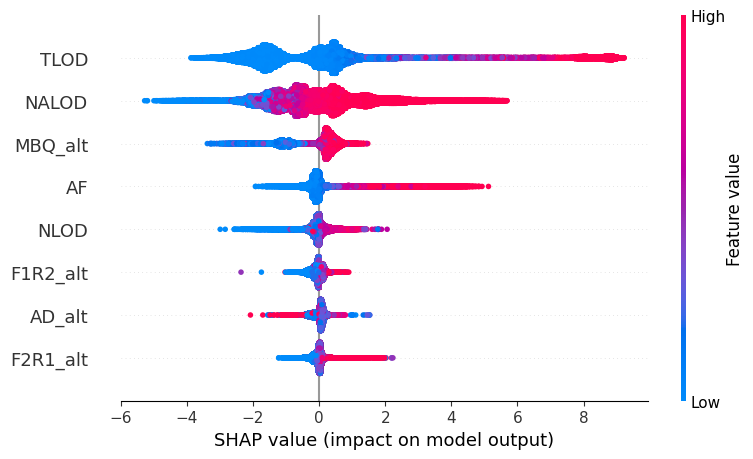

In [15]:
# Global SHAP summary plot
shap.summary_plot(shap_values_combined, X_test_combined, feature_names=all_features)

| Element | Meaning |
|--------|---------|
| **Each dot** | A variant (sample) |
| **X-axis (SHAP value)** | Impact of feature on the model's prediction for being GOLDEN |
| **Color** | Feature value (red = high, blue = low) |
| **Vertical spread** | Distribution of SHAP values for that feature across all variants |
| **Left (negative SHAP)** | Pushes prediction toward NOT GOLDEN (class 0) |
| **Right (positive SHAP)** | Pushes prediction toward GOLDEN (class 1) |

## Generate prompt

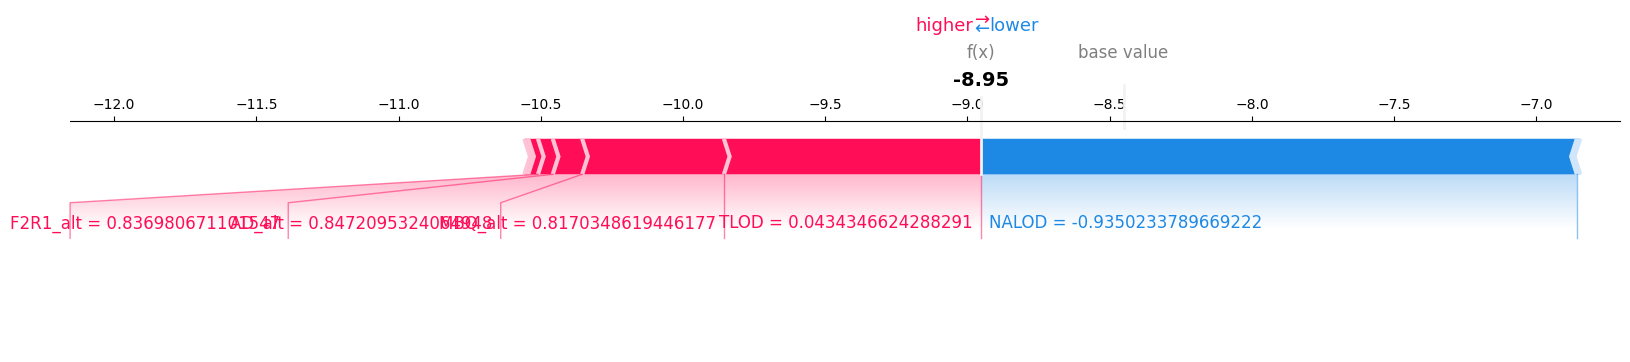

In [16]:
variant_idx = 5

force_plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values_combined[variant_idx],
    features=X_test_combined.iloc[variant_idx],
    feature_names=all_features,
    matplotlib=True
)

In [17]:
variant_shap = shap_values_combined[variant_idx]
variant_features = X_test_combined.iloc[variant_idx]

variant_df = pd.DataFrame({
    "feature": all_features,
    "value": variant_features.values,
    "shap": variant_shap
})

variant_df["abs_shap"] = variant_df["shap"].abs()
variant_df = variant_df.sort_values(by="abs_shap", ascending=False)

print(variant_df.head(5))

    feature     value      shap  abs_shap
5     NALOD -0.935023 -2.094880  2.094880
0      TLOD  0.043435  0.903917  0.903917
7   MBQ_alt  0.817035  0.498428  0.498428
3    AD_alt  0.847210  0.103364  0.103364
2  F2R1_alt  0.836981  0.052048  0.052048


In [18]:
top_n = 5
explanation = "\n".join([
    f"- {row['feature']} had value {row['value']} and contributed SHAP value {row['shap']:.3f}"
    for _, row in variant_df.head(top_n).iterrows()
])

pred = "high confidence" if np.sum(variant_shap) > 0 else "probable false positive"

In [19]:
prompt = f"""A variant was classified as **{pred}** by a LightGBM model.
Here are the top contributing features and their effects:

{explanation}

Please explain in plain English why this variant was predicted as {pred}, using this information.
"""
print(prompt)

A variant was classified as **probable false positive** by a LightGBM model.
Here are the top contributing features and their effects:

- NALOD had value -0.9350233789669222 and contributed SHAP value -2.095
- TLOD had value 0.0434346624288291 and contributed SHAP value 0.904
- MBQ_alt had value 0.8170348619446177 and contributed SHAP value 0.498
- AD_alt had value 0.8472095324064948 and contributed SHAP value 0.103
- F2R1_alt had value 0.836980671101547 and contributed SHAP value 0.052

Please explain in plain English why this variant was predicted as probable false positive, using this information.

